In [32]:
import numpy as np
import matplotlib.pyplot as plt
import osagent_quapsel

plt.rcParams["figure.figsize"] = (12,8)
DPI = 100

### Defect and Rewards

In [8]:
def plot_defect_and_rewards(logfolder="./logs", xmin = 2000, xmin_fit=None, fit=True):
    if xmin_fit is None:
        xmin_fit = xmin
    defect = np.loadtxt(f"{logfolder}/defect.log")
    episode_defect = np.loadtxt(f"{logfolder}/ep_defect.log")
    rewards = np.loadtxt(f"{logfolder}/reward.log") 

    fig, ax = plt.subplots(1,2,figsize=(12,4), dpi=DPI)

    x = range(xmin, len(episode_defect))
    ax[0].plot(x, episode_defect[xmin:])
    if fit:
        xfit = range(xmin_fit, len(episode_defect))
        p = np.poly1d(np.polyfit(xfit, episode_defect[xmin_fit:], 1))
        ax[0].plot(xfit, p(xfit), "r--")
    ax[0].set_title("Mean squared error of Q-estimator")
    ax[0].set_xlabel("Episodes")
    ax[0].set_ylabel("Mean squared error")
    ax[0].set_xlim([xmin, len(episode_defect)])

    x = range(xmin, len(rewards))
    ax[1].plot(x, rewards[xmin:])
    if fit:
        xfit = range(xmin_fit, len(rewards))
        p = np.poly1d(np.polyfit(xfit, rewards[xmin_fit:], 1))
        ax[1].plot(xfit, p(xfit), "r--")
    ax[1].set_title("Mean reward per step")
    ax[1].set_xlabel("Episodes")
    ax[1].set_ylabel("Reward")
    ax[1].set_xlim([xmin, len(rewards)])

    plt.show()

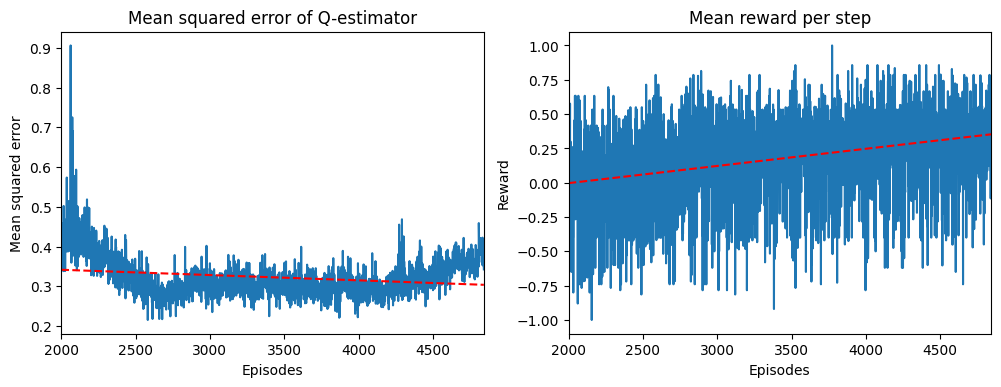

In [11]:
plot_defect_and_rewards(xmin=2000, xmin_fit=2000)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from operator import add

def plot_imitation_exploitation_exploration(episodes, epsilon, imitation_rate, epsilon_decay, imitation_rate_decay, stop_imitation_at=-1, figsize=(10,3)):
    epsilon_arr = []
    imitation_rate_arr = []
    prediction_arr = []
    for i in range(episodes):

        imitation_rate_arr.append(imitation_rate)
        epsilon_arr.append(epsilon*(1-imitation_rate))
        prediction_arr.append((1-epsilon)*(1-imitation_rate))

        if i == stop_imitation_at:
            imitation_rate = 0
        elif imitation_rate != 0:
            imitation_rate *= imitation_rate_decay
        epsilon *= epsilon_decay

    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    ax.plot(epsilon_arr, label="Exploration")
    ax.plot(imitation_rate_arr, label="Imitation")
    ax.plot(prediction_arr, label="Exploitation")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Probability")

    ax.set_ylim([0, 1])
    ax.set_xlim([0, episodes])

    ax.legend()
    plt.show()

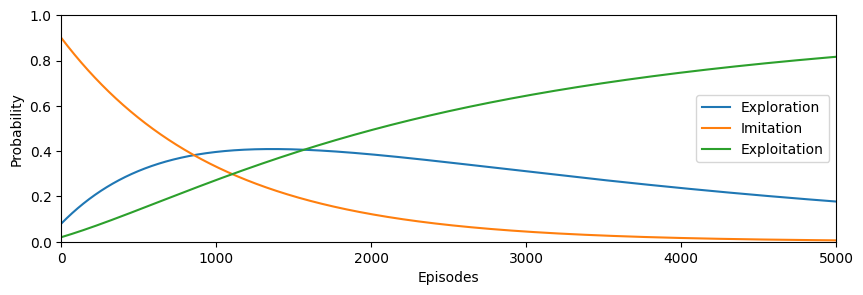

In [24]:
plot_imitation_exploitation_exploration(episodes=5000, epsilon=0.8, imitation_rate=0.9, epsilon_decay=0.9997, imitation_rate_decay=0.999)

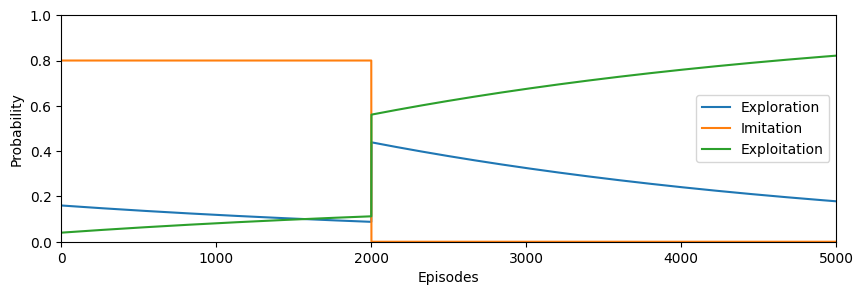

In [25]:
plot_imitation_exploitation_exploration(episodes=5000, epsilon=0.8, imitation_rate=0.8, epsilon_decay=0.9997, imitation_rate_decay=1, stop_imitation_at=2000)

### Runtime of act function for 5 rounds played

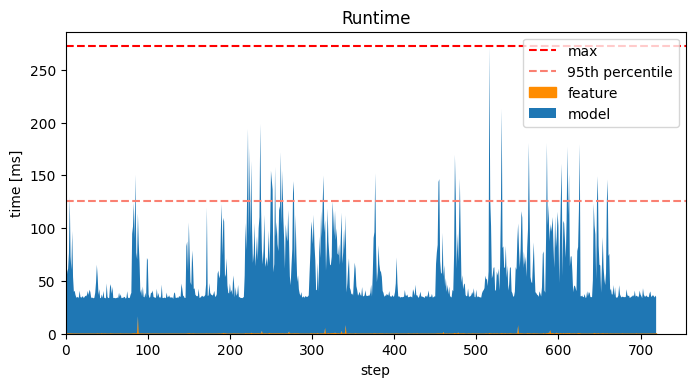

(0.17, 16.41, 0.3563611111111112)


In [308]:
def plot_act_times():
    timings = np.loadtxt("./logs/timing_act.log", delimiter=',')

    t_feature = timings[:,0]
    t_complete = timings[:, 1]

    N = len(t_feature)

    fig, ax = plt.subplots(figsize=(8, 4), dpi=DPI)


    t_complete[0] = 150
    max_time = np.max(t_complete)
    percentile_95 = np.percentile(t_complete, 95)

    ax.fill_between(range(N), t_feature, color='darkorange', label="feature")
    ax.fill_between(range(N), t_feature , t_complete, label="model")

    plt.axhline(y=max_time, color='red', linestyle='--', label='max')
    plt.axhline(y=percentile_95, color='salmon', linestyle='--', label='95th percentile')

    ax.set_title("Runtime")
    ax.set_ylabel("time [ms]")
    ax.set_xlabel("step")
    ax.legend(loc='upper right')

    ax.set_xlim(0)
    ax.set_ylim(0)

    plt.show()
    print((min(t_feature), max(t_feature), np.mean(np.array(t_feature))))

DPI = 100
os.system("python3 ../../main.py play --my-agent deep_quapsel --n-rounds 5 --no-gui")
plot_act_times()

### Training time

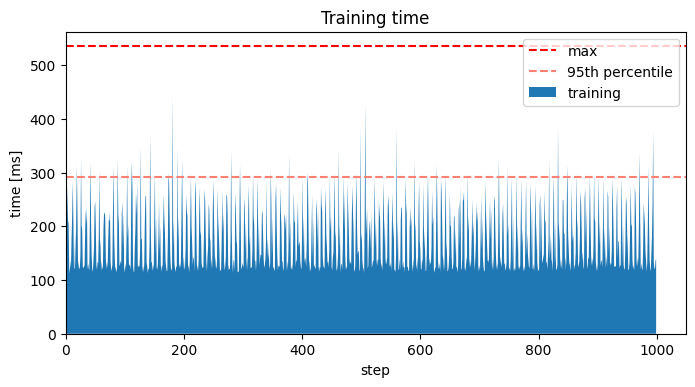

In [28]:
t_train = np.loadtxt("./logs/timing_train.log")[:1000]

N = len(t_train)

fig, ax = plt.subplots(figsize=(8, 4), dpi=DPI)

max_time = np.max(t_train)
percentile_95 = np.percentile(t_train, 95)

ax.fill_between(range(N), t_train, label="training")

plt.axhline(y=max_time, color='red', linestyle='--', label='max')
plt.axhline(y=percentile_95, color='salmon', linestyle='--', label='95th percentile')

ax.set_title("Training time")
ax.set_ylabel("time [ms]")
ax.set_xlabel("step")
ax.legend(loc='upper right')
ax.set_xlim(0)
ax.set_ylim(0)

plt.show()

### Evaluate Score

In [30]:
import json
import os

STATSFILE = "stats.json"
def evaluate_performance(rounds, agent="deep_quapsel"):
    if os.path.exists(STATSFILE):
        os.remove(STATSFILE)
    os.system(f"python3 ../../main.py play --my-agent {agent} --no-gui --n-rounds {rounds} --save-stats {STATSFILE}")

def plot_performance(figsize=(8,4)):
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    with open(STATSFILE, 'r') as f:
        stats = json.load(f)
        rounds = len(stats["by_round"])
        by_agent = stats["by_agent"]
        agent_score = [by_agent[agent]["score"] for agent in by_agent.keys()]
        suicides = [(agent, by_agent[agent].get("suicides", 0)) for agent in by_agent.keys()]

        from_coins = np.array([by_agent[agent].get("coins", 0) for agent in by_agent.keys()])
        from_kills =  5 * np.array([by_agent[agent].get("kills", 0) for agent in by_agent.keys()])

        ax.bar(by_agent.keys(), from_coins / rounds, label = "coins")
        ax.bar(by_agent.keys(), from_kills / rounds, bottom = from_coins / rounds, label = "kills")
        
        ax.title.set_text(f"Agent performance in {rounds} rounds")
        ax.set_ylabel("average score per round")
        ax.legend()
        
    print(f"Suicides: {suicides}")

    print(f"Total agent score: {agent_score[0]}, other agents: {agent_score[1:]}")
    print(f"Average score per round: {agent_score[0]/rounds}")
    print(f"Percentage of points achieved: {100*np.round(agent_score[0]/sum(agent_score), 2)}%")

    plt.show()

#### Against rule_based_agents
Evaluation of deep_quapsel against three rule_based_agents (100 rounds)

100%|██████████| 100/100 [12:07<00:00,  7.27s/it]


Suicides: [('deep_quapsel', 69), ('rule_based_agent_0', 50), ('rule_based_agent_1', 42), ('rule_based_agent_2', 46)]
Total agent score: 147, other agents: [349, 361, 368]
Average score per round: 1.47
Percentage of points achieved: 12.0%


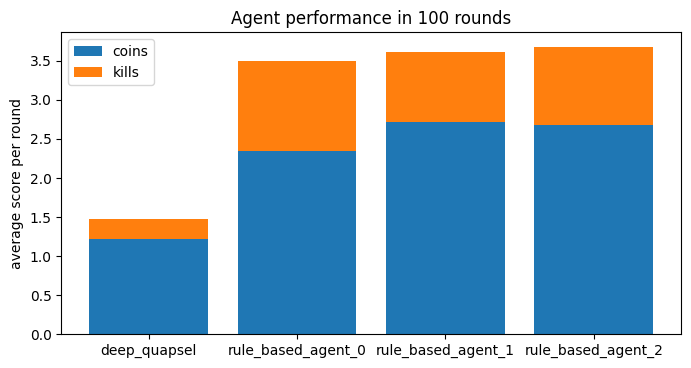

In [31]:
evaluate_performance(rounds=100)
plot_performance()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 4, 32)          2080      
                                                                 
 activation (Activation)     (None, 4, 4, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 activation_1 (Activation)   (None, 2, 2, 64)          0         
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 6)                 7

100%|██████████| 100/100 [11:06<00:00,  6.66s/it]


Total agent score: 175, other agents: [365, 408, 299]
Average score per round: 1.75
Percentage of points achieved: 14.000000000000002%


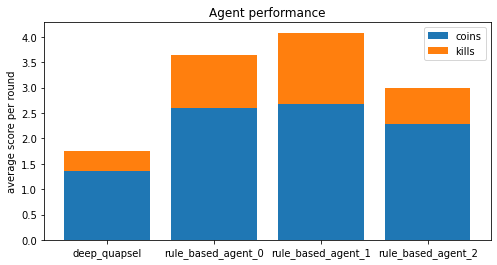

In [59]:
evaluate_performance(rounds=100)
plot_performance()

#### Against agent_quapsel and rule_based_agents
Evaluation of deep_quapsel against agent_quapsel together with two rule_based_agents (100 rounds)

##### First evaluation

In [ ]:
rounds = 100
if os.path.exists(STATSFILE):
    os.remove(STATSFILE)
os.system(f"python3 ../../main.py play --agents deep_quapsel agent_quapsel rule_based_agent rule_based_agent --no-gui --n-rounds {rounds} --save-stats {STATSFILE}")

Suicides: [('agent_quapsel', 29), ('deep_quapsel', 68), ('rule_based_agent_0', 43), ('rule_based_agent_1', 30)]
Total agent score: 361, other agents: [156, 305, 348]
Average score per round: 3.61
Percentage of points achieved: 31.0%


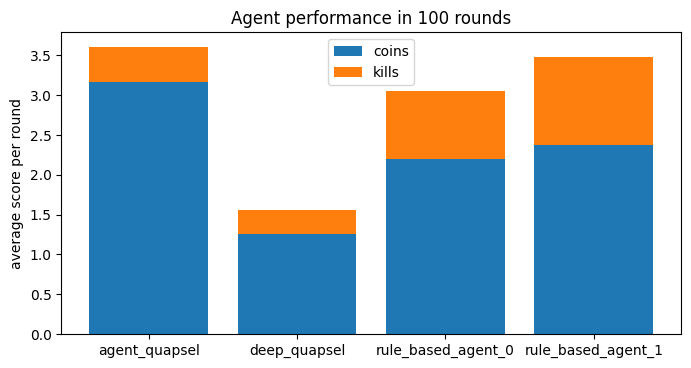

In [218]:
plot_performance(figsize=(8,4))

##### Second evaluation

100%|██████████| 100/100 [15:20<00:00,  9.21s/it]


Total agent score: 356, other agents: [149, 298, 344]
Average score per round: 3.56
Percentage of points achieved: 31.0%


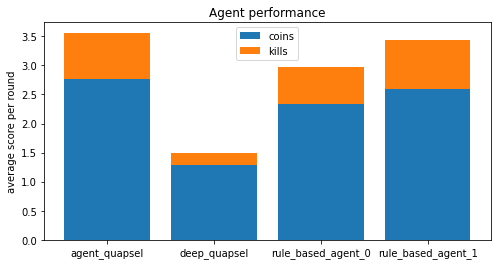

In [63]:
rounds = 100
if os.path.exists(STATSFILE):
    os.remove(STATSFILE)
os.system(f"python3 ../../main.py play --agents deep_quapsel agent_quapsel rule_based_agent rule_based_agent --no-gui --n-rounds {rounds} --save-stats {STATSFILE}")
plot_performance()

#### Against agent_quapsel
Play only agent_quapsel against deep_quapsel (100 rounds)

100%|██████████| 100/100 [18:19<00:00, 11.00s/it]


Total agent score: 618, other agents: [161]
Average score per round: 6.18
Percentage of points achieved: 79.0%


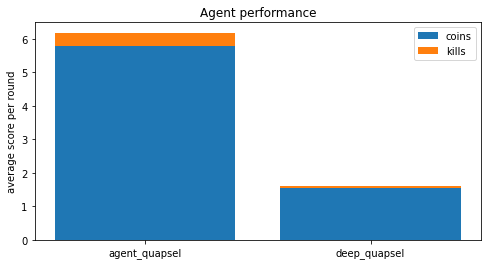

In [83]:
rounds = 100
if os.path.exists(STATSFILE):
    os.remove(STATSFILE)
os.system(f"python3 ../../main.py play --agents deep_quapsel agent_quapsel --no-gui --n-rounds {rounds} --save-stats {STATSFILE}")
plot_performance()